# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'boxer_16.jpg'

In [6]:
maps[0]

'._Abyssinian_1.png'

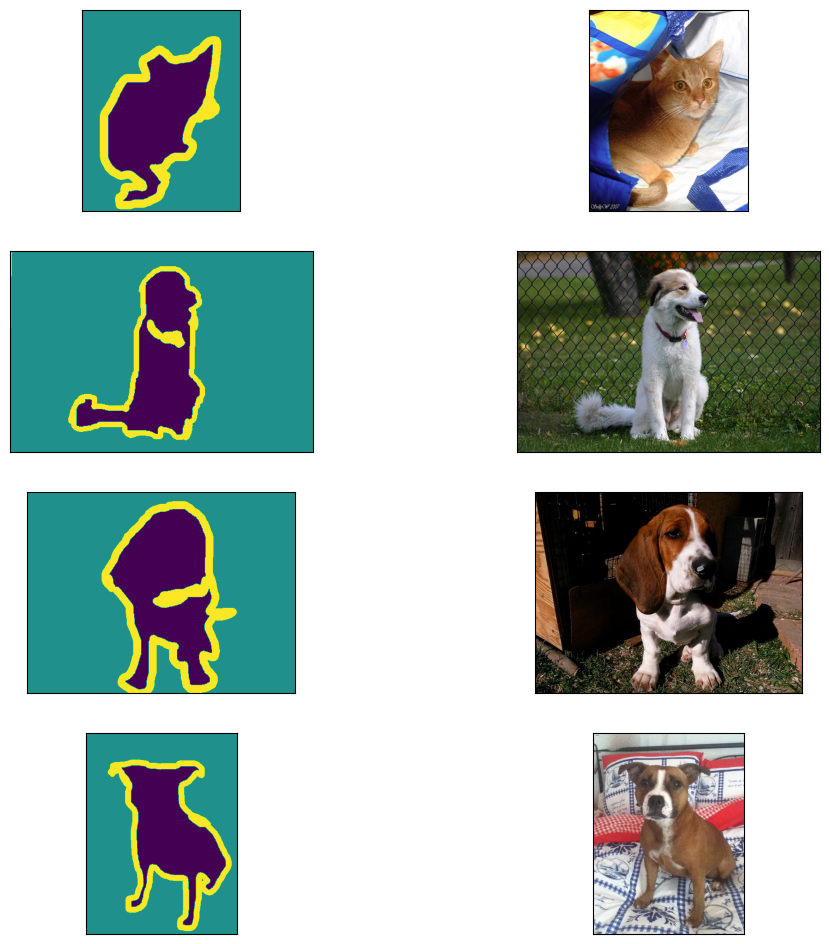

In [7]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [8]:
#Filter out hidden files
maps = [f for f in os.listdir(trimaps_dir) if not f.startswith('._')]


img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))


[1 2 3]


# SageMaker Setup

In [12]:
# Initialize an S3 client
s3 = boto3.client('s3')

# Define the bucket name
#Bucket name should be in lowercase
bucket_name = 'segmentdata-atulkumar'  #Provide a unique name (segmentdata-<your name>)

# Create the bucket
try:
    response = s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint': boto3.Session().region_name 
        }
    )
    print(f"Bucket {bucket_name} created successfully!")
except Exception as e:
    print(f"Error creating bucket: {e}")


Bucket segmentdata-atulkumar created successfully!


In [13]:
role = sagemaker.get_execution_role()
training_image = sagemaker.image_uris.retrieve('semantic-segmentation', boto3.Session().region_name)
print(training_image)


433757028032.dkr.ecr.us-west-2.amazonaws.com/semantic-segmentation:1


In [14]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [15]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:03<00:00, 2293.88it/s]


In [16]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [17]:
print(len(train_annots), len(train_images))

5515 5515


# Uploading Data to S3

In [18]:
%%time
sess = sagemaker.Session()

print('Starting upload..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 1min 21s, sys: 9.86 s, total: 1min 31s
Wall time: 16min 20s


In [19]:
s3_validation_annotation_path

's3://segmentdata-atulkumar/validation_annotation'

# SageMaker Estimator

In [22]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1, 
    instance_type='ml.p3.2xlarge',  
    volume_size=100,  
    max_run=36000,  
    input_mode='File',
    output_path='s3://petssegmentdata/output',
    sagemaker_session=sess
)


# Hyperparameters

In [23]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

# Data Channels

In [24]:
from sagemaker.inputs import TrainingInput

train_data = TrainingInput(s3_train_path, distribution='FullyReplicated',
                           content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = TrainingInput(s3_validation_path, distribution='FullyReplicated',
                                content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                                      content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                                           content_type='image/png', s3_data_type='S3Prefix')


In [25]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

# Model Training

In [26]:
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2024-10-25-06-23-11-257


2024-10-25 06:23:12 Starting - Starting the training job
2024-10-25 06:23:12 Pending - Training job waiting for capacity......
2024-10-25 06:23:57 Pending - Preparing the instances for training...
2024-10-25 06:24:40 Downloading - Downloading input data...
2024-10-25 06:25:15 Downloading - Downloading the training image.................................
2024-10-25 06:30:38 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Oct 25 06:31:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id         

# Deploy Model

In [28]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')


INFO:sagemaker:Creating model with name: semantic-segmentation-2024-10-25-07-02-38-848
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2024-10-25-07-02-38-848
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2024-10-25-07-02-38-848


-------------------!
Model deployed!


# Predictions

In [29]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1875


In [30]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [31]:
index = 583

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [33]:
import io

mask = np.array(Image.open(io.BytesIO(results)))

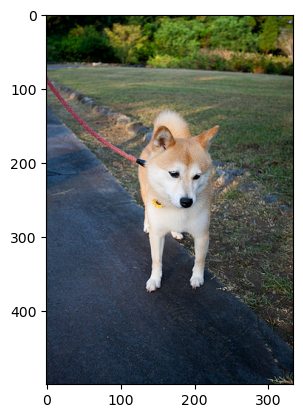

In [36]:
plt.imshow(plt.imread(image_path));

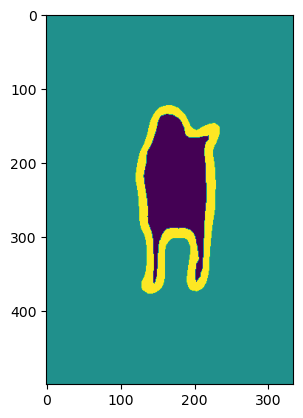

In [37]:
plt.imshow(mask);

Delete endpoint

In [46]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)